In [53]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [54]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [55]:
print(tf.__version__)

2.12.0


In [56]:
tf.random.set_seed(42)
np.random.seed(42)

In [68]:
train_df = pd.read_csv('data/train.csv', index_col=0).drop('Coin_timestamp',axis=1)
val_df = pd.read_csv('data/val.csv', index_col=0).drop('Coin_timestamp',axis=1)
test_df = pd.read_csv('data/test.csv', index_col=0).drop('Coin_timestamp',axis=1)
print(train_df.shape, val_df.shape, test_df.shape)

(2151, 7) (614, 7) (308, 7)


In [69]:
train_df.head()

,Open,High,Low,Close,Volume,CionScore,UpDown
0,0.010909,0.009038,0.011130,0.010638,0.000274,0.394260,1.0
1,0.010731,0.008742,0.010713,0.010195,0.000214,0.597569,0.0
2,0.010274,0.008349,0.009911,0.009390,0.000337,0.440592,0.0
3,0.009482,0.007685,0.008210,0.007804,0.000557,0.440592,0.0
4,0.007877,0.006544,0.006264,0.007371,0.001044,0.440592,0.0


In [70]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='UpDown', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [71]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [72]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## CNN 

### Multi-step model 

In [82]:
KERNEL_WIDTH = 4
LABEL_WIDTH = 28
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['UpDown'])

In [78]:
# Values obtained from chapter 15

ms_mae_val = []
ms_mae_test = []

In [83]:
ms_cnn_model = Sequential([
    Conv1D(64, kernel_size=(KERNEL_WIDTH)),
    # LSTM(32, return_sequences=True),    
    Dense(1),
])

history = compile_and_fit(ms_cnn_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
67/67 [==============================] - 1s 4ms/step - loss: 0.2679 - mean_absolute_error: 0.4982 - val_loss: 0.2594 - val_mean_absolute_error: 0.4968
Epoch 2/50
67/67 [==============================] - 0s 3ms/step - loss: 0.2481 - mean_absolute_error: 0.4918 - val_loss: 0.2682 - val_mean_absolute_error: 0.4970
Epoch 3/50
67/67 [==============================] - 0s 3ms/step - loss: 0.2474 - mean_absolute_error: 0.4913 - val_loss: 0.2603 - val_mean_absolute_error: 0.4961
Epoch 4/50
19/19 [==============================] - 0s 1ms/step - loss: 0.2624 - mean_absolute_error: 0.4911


#### CNN + LSTM 

In [40]:
ms_cnn_lstm_model = Sequential([
    Conv1D(128, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(64, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_lstm_model, multi_window)

ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
67/67 [==============================] - 3s 18ms/step - loss: 0.0197 - mean_absolute_error: 0.0808 - val_loss: 1.5636 - val_mean_absolute_error: 1.0970
Epoch 2/50
67/67 [==============================] - 1s 14ms/step - loss: 0.0026 - mean_absolute_error: 0.0280 - val_loss: 1.3346 - val_mean_absolute_error: 1.0075
Epoch 3/50
67/67 [==============================] - 1s 13ms/step - loss: 0.0020 - mean_absolute_error: 0.0247 - val_loss: 1.3260 - val_mean_absolute_error: 0.9962
Epoch 4/50
67/67 [==============================] - 1s 13ms/step - loss: 0.0018 - mean_absolute_error: 0.0234 - val_loss: 1.3829 - val_mean_absolute_error: 1.0228
Epoch 5/50
67/67 [==============================] - 1s 13ms/step - loss: 0.0017 - mean_absolute_error: 0.0220 - val_loss: 1.3236 - val_mean_absolute_error: 0.9917
Epoch 6/50
67/67 [==============================] - 1s 13ms/step - loss: 0.0017 - mean_absolute_error: 0.0215 - val_loss: 1.3294 - val_mean_absolute_error: 0.9963
Epoch 7/50
67/67 [====

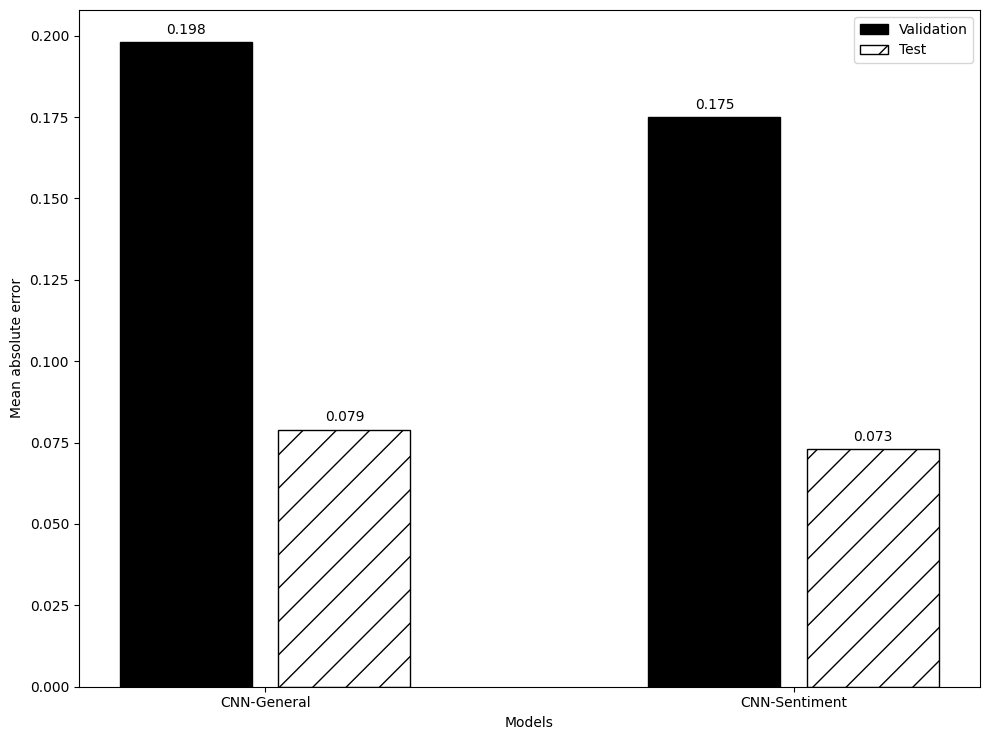

In [52]:
ms_mae_val.extend([v[1] for v in ms_val_performance.values()])
ms_mae_test.extend([v[1] for v in ms_performance.values()])

x = np.arange(2)

labels = ['CNN-General','CNN-Sentiment',]

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH16_F07_peixeiro.png', dpi=300)